In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [3]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Normal learning in SanDiego

In [22]:
pred = {}
n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'

for random_seed in range(10):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [ ]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

In [27]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt_transfer = {}
n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
#     T_adapt_transfer[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
#         print "adapt percentage: ", adapt_percentage
        rd = 0
#         T_adapt_transfer[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a, T_known=np.ones(12).reshape(-1, 1))
#             T_transfer_reg[random_seed][train_percentage][rd] = T
#             A_transfer_reg[random_seed][train_percentage][rd] = A
#             H_transfer_reg[random_seed][train_percentage].append(H)
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            

random seed:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
test_i

In [28]:
out = {}
for random_seed in range(10):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [29]:
out_transfer = {}
for random_seed in range(10):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out = mean_out.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})

In [40]:
mean_out_2k = mean_out.rename(columns={'dw_normal':'dw_normal_2k', 'fridge_normal':'fridge_normal_2k', 'hvac_normal':'hvac_normal_2k',
                                             'mw_normal':'mw_normal_2k', 'oven_normal':"oven_normal_2k", 'wm_normal':'wm_normal_2k'})
mean_out_transfer_2k = mean_out_transfer.rename(columns={'dw_transfer':'dw_transfer_2k', 'fridge_transfer':'fridge_transfer_2k', 'hvac_transfer':'hvac_transfer_2k',
                                             'mw_transfer':'mw_transfer_2k', 'oven_transfer':"oven_transfer_2k", 'wm_transfer':'wm_transfer_2k'})

all_out_2k = pd.concat([mean_out_2k, mean_out_transfer_2k], axis=1)

In [38]:
mean_out_10k = mean_out.rename(columns={'dw_normal':'dw_normal_10k', 'fridge_normal':'fridge_normal_10k', 'hvac_normal':'hvac_normal_10k',
                                             'mw_normal':'mw_normal_10k', 'oven_normal':"oven_normal_10k", 'wm_normal':'wm_normal_10k'})
mean_out_transfer_10k = mean_out_transfer.rename(columns={'dw_transfer':'dw_transfer_10k', 'fridge_transfer':'fridge_transfer_10k', 'hvac_transfer':'hvac_transfer_10k',
                                             'mw_transfer':'mw_transfer_10k', 'oven_transfer':"oven_transfer_10k", 'wm_transfer':'wm_transfer_10k'})

all_out_10k = pd.concat([mean_out_10k, mean_out_transfer_10k], axis=1)

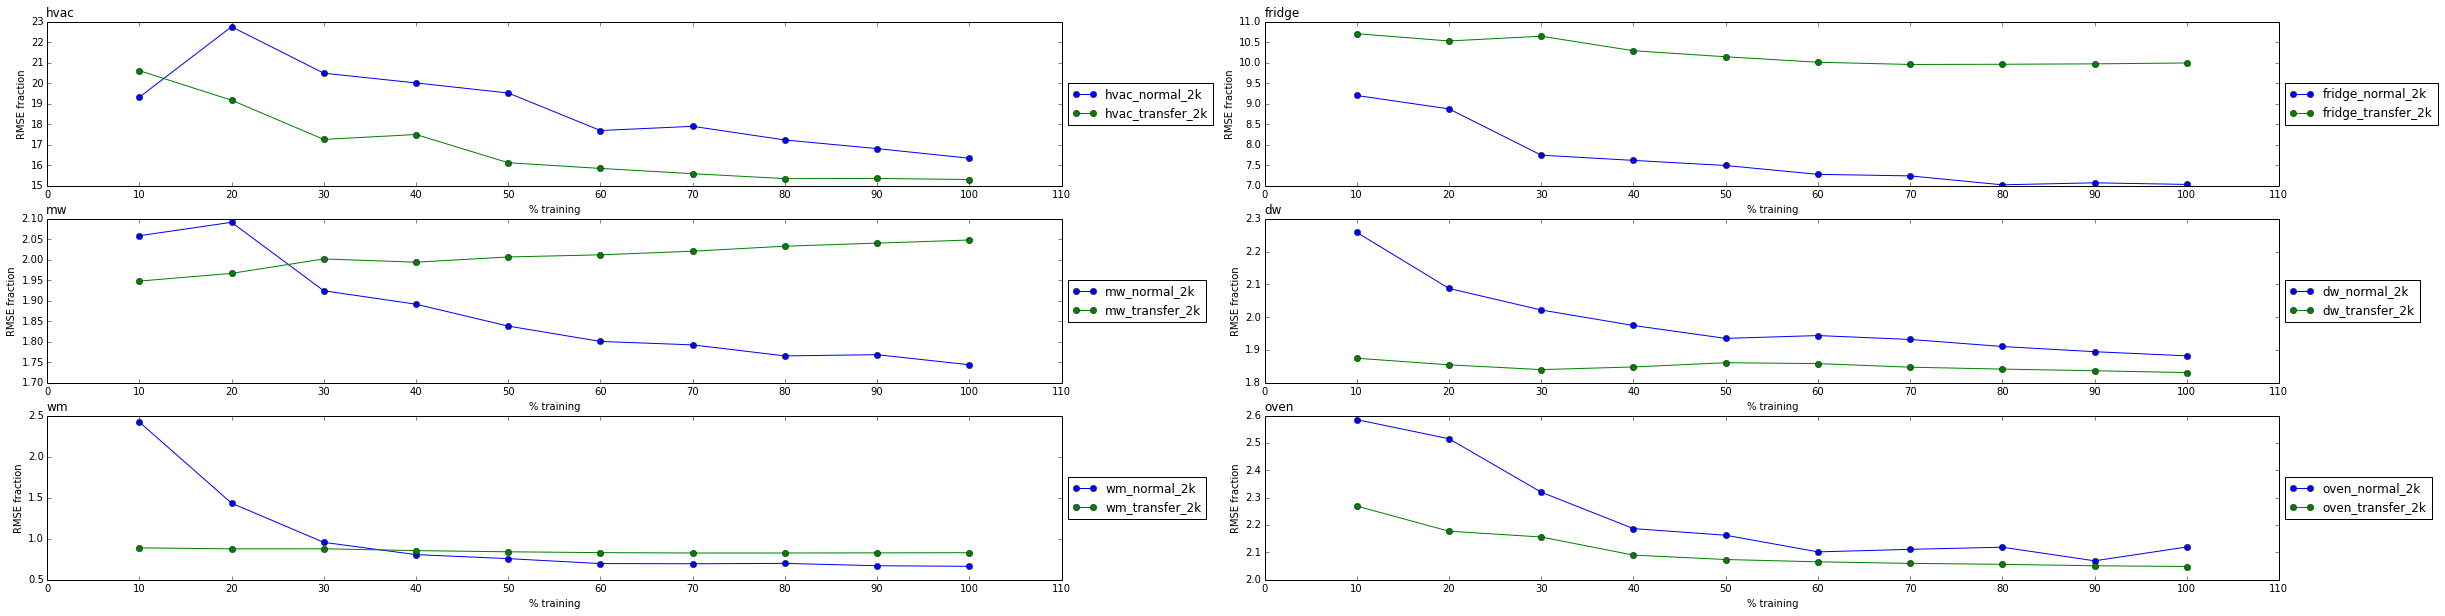

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 100))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out_10k[appliance + '_normal_10k']
    df2 = all_out_10k[appliance + '_transfer_10k']
    df3 = all_out_2k[appliance + '_normal_2k']
    df4 = all_out_2k[appliance + '_transfer_2k']
#     df4 = all_out[appliance+ '_transfer_reg']

#     df = pd.concat([df3, df4], axis=1)
    df = pd.concat([df1, df2, df3, df4], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(40, 10), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/0711/prediction_normal_transfer_10k_2k", bbox_inches="tight", dpi=300, format="pdf")

### -------------------------------------------------------------------------------------------------------------------------------
### Regularization exploration

## Normal learning with regularization term

In [67]:
pred_reg = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'

for random_seed in range(10):
    pred_reg[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_reg[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(1):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT_reg(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_reg[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [68]:
out_reg = {}
for random_seed in range(1):
    out_reg[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_reg[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_reg[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

### Transfer learning 

In [71]:
from scipy.optimize import nnls

pred_transfer_reg = {}
# T_adapt_transfer = {}
n_splits = 10
case = 2
a = 2
b=2
cost = 'abs'


for random_seed in range(1):
    pred_transfer_reg[random_seed] = {}
#     T_adapt_transfer[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer_reg[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(1):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
#         print "adapt percentage: ", adapt_percentage
        rd = 0
#         T_adapt_transfer[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT_reg(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_reg)
#             T_transfer_reg[random_seed][train_percentage][rd] = T
#             A_transfer_reg[random_seed][train_percentage][rd] = A
#             H_transfer_reg[random_seed][train_percentage].append(H)
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer_reg[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            

random seed:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
test_i

In [72]:
out_transfer_reg = {}
for random_seed in range(1):
    out_transfer_reg[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_reg[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_reg[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [74]:
mean_out= pd.Panel(out).mean(axis=0)
mean_out_reg = pd.Panel(out_reg).mean(axis=0)
mean_out_transfer_reg = pd.Panel(out_transfer_reg).mean(axis=0)
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)

# df_out_normal = pd.DataFrame(out_normal)]
mean_out = mean_out.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
mean_out_reg = mean_out_reg.rename(columns={'dw':'dw_normal_reg', 'fridge':'fridge_normal_reg', 'hvac':'hvac_normal_reg',
                                             'mw':'mw_normal_reg', 'oven':"oven_normal_reg", 'wm':'wm_normal_reg'})
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out_transfer_reg = mean_out_transfer_reg.rename(columns={'dw':'dw_transfer_reg', 'fridge':'fridge_transfer_reg', 'hvac':'hvac_transfer_reg',
                                             'mw':'mw_transfer_reg', 'oven':"oven_transfer_reg", 'wm':'wm_transfer_reg'})

all_out = pd.concat([mean_out, mean_out_reg], axis=1)
all_out = pd.concat([all_out, mean_out_transfer], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_reg], axis=1)

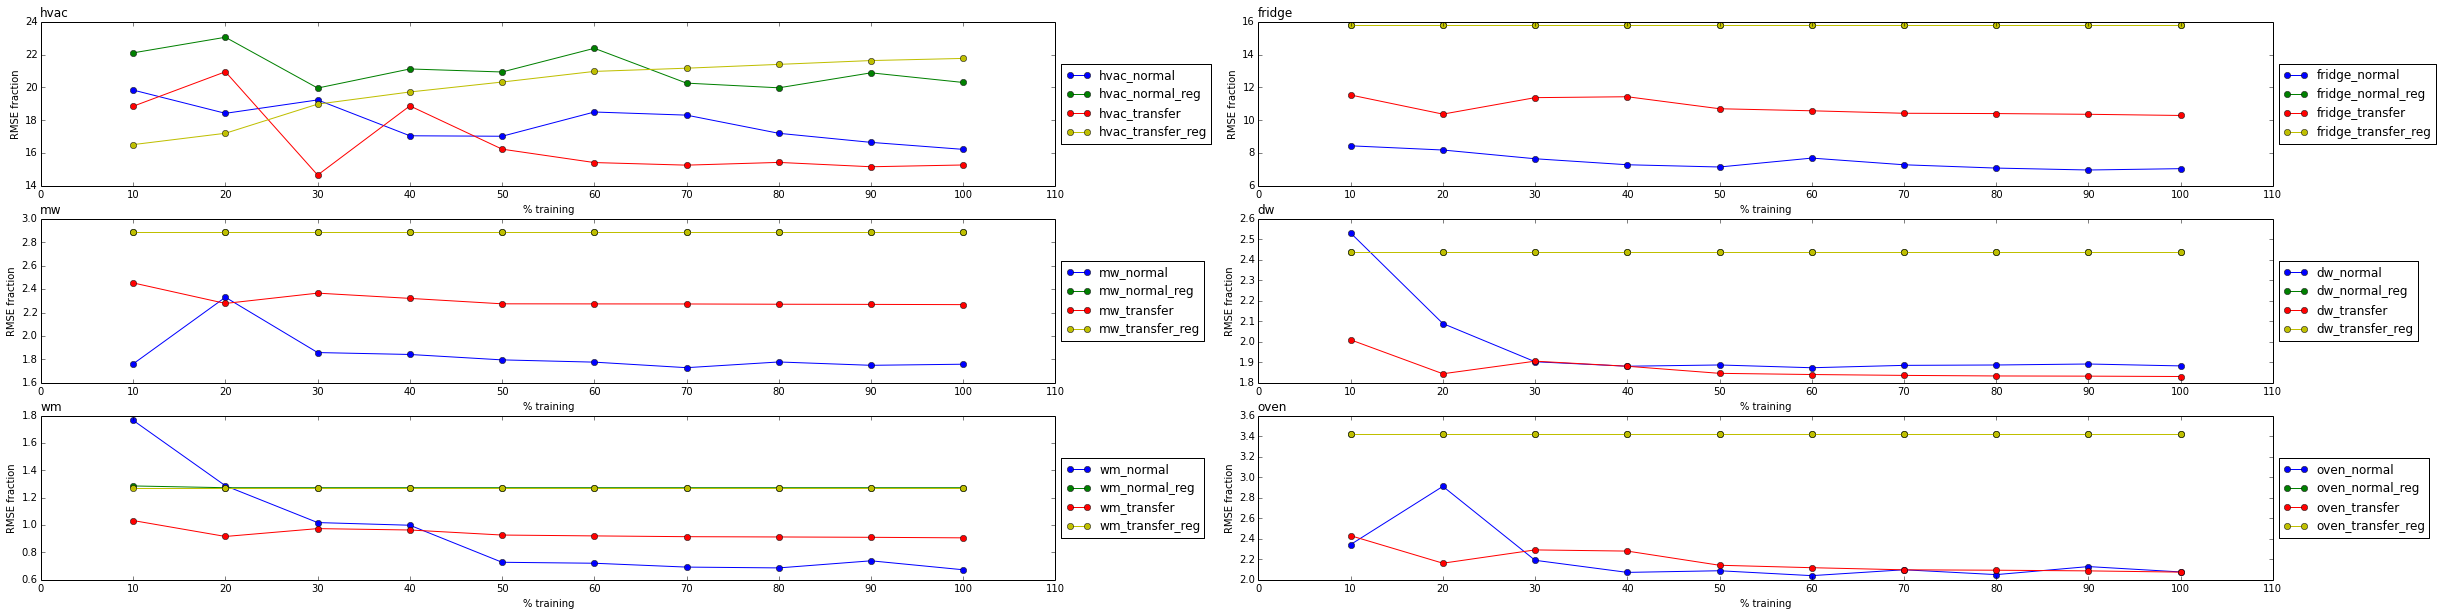

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 100))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_normal']
    df2 = all_out[appliance+ '_normal_reg']
    df3 = all_out[appliance+ '_transfer']
    df4 = all_out[appliance+ '_transfer_reg']

#     df = pd.concat([df1, df2], axis=1)
    df = pd.concat([df1, df2, df3, df4], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(40, 10), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/0705/prediction_normal_transfer", bbox_inches="tight", dpi=300)

In [64]:
import autograd.numpy as np
from numpy import linalg as LA
from autograd import multigrad

def cost_abs_reg(H, A, T, E_np_masked, case):
    la = 10
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error = (HAT - E_np_masked)[mask].flatten() + la * LA.norm(~np.isnan(H)) + la * LA.norm(~np.isnan(A)) + la * LA.norm(~np.isnan(T))
    return np.sqrt((error ** 2).mean())

def learn_HAT_reg(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, random_mul_constant=1,
              random_add_constant=0):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs_reg
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)*random_mul_constant+random_add_constant

    A = np.random.rand(*A_dim)*random_mul_constant+random_add_constant
    T = np.random.rand(*T_dim)*random_mul_constant+random_add_constant

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T